#**DDoS Detection in Software-Defined Networks using Machine learning**

## Install & Import necessary libraries and packages

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
import seaborn as sns
sns.set_palette('tab10')
import gc

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve,roc_curve 
from sklearm.metrics import accuracy_score,precision_score,recall_score,f1_score,plot_confusion_matrix, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

gc.collect()


0

## Load the data set

In [ ]:
#Defining data types to minimize memmory usage
dtypes = {
    'src_ip': 'category',
    'src_port': 'uint16',
    'dst_ip': 'category',
    'dst_port': 'uint16',
    'protocol': 'category',
    'flow_duration': 'uint32',
    'fwd_pkt_len_max': 'float32',
    'fwd_pkt_len_min': 'float32',
    'bwd_pkt_len_max': 'float32',
    'bwd_pkt_len_min': 'float32', 
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'float32',
    'flow_iat_min': 'float32',
    'fwd_iat_tot': 'float32',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'fwd_pkts/s': 'float32',
    'bwd_pkts/s': 'float32',
    'pkt_len_min': 'float32',
    'pkt_len_max': 'float32',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'syn_flag_cnt': 'category',
    'rst_flag_cnt': 'category',
    'psh_flag_cnt': 'category',
    'ack_flag_cnt': 'category',
    'ece_flag_cnt': 'category',
    'cwe_flag_cnt': 'category',
    'down/up_ratio': 'float32',
    'pkt_size_avg': 'float32',      
    'init_fwd_win_byts': 'uint32',
    'init_bwd_win_byts': 'uint32',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'float32',
    'active_min': 'float32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'float32',
    'idle_min': 'float32',
    'label': 'category'
}
gc.collect()

22

In [ ]:
#loading dataset from google drive
df = pd.read_csv(
    '/content/drive/MyDrive/output.csv',
    dtype=dtypes,
    usecols=[*dtypes.keys()],
    engine='c',
    low_memory=True
)
del dtypes
gc.collect()

0

## Data cleaning 


In [ ]:
df=df.drop(['src_ip','dst_ip'],axis=1)
gc.collect()

22

In [ ]:
cols=['label','protocol','syn_flag_cnt','ack_flag_cnt','rst_flag_cnt','psh_flag_cnt','cwe_flag_cnt','ece_flag_cnt',]
for col in cols:
  df[col]=df[col].astype('uint16')
del cols
gc.collect()

22

In [ ]:
y=df['label']
X=df.drop('label',axis=1)
del df
gc.collect()

22

## Split the data into train & test sets


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)
del X,y
gc.collect()

43

## Scaling the data

In [ ]:
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

gc.collect()

21939

In [ ]:
scaler.fit(y_train)
y_train=scaler.transform(y_train)
y_test=scaler.transform(y_test)
gc.collect()

50

## Fitting the ML models

### Random Forest

In [ ]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
gc.collect()

24

In [ ]:
#Evaluating on test set
RF_pred=clf.predict(X_test)

#Scores
print(accuracy_score(y_test,RF_pred))
print(precision_score(y_test,RF_pred))
print(recall_score(y_test,RF_pred))
print(f1_score(y_test,RF_pred))



0.9999494957171878
0.999946887203872
0.9999536467009488
0.9999502669409871


In [ ]:
#Classification report
classification_report(y_test,RF_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00   1003906\n           1       1.00      1.00      1.00   1035525\n\n    accuracy                           1.00   2039431\n   macro avg       1.00      1.00      1.00   2039431\nweighted avg       1.00      1.00      1.00   2039431\n'

In [ ]:
#Confusion Matrix
RF_cm=confusion_matrix(y_test,RF_pred)
print(RF_cm)

[[1003862      44]
 [     38 1035487]]


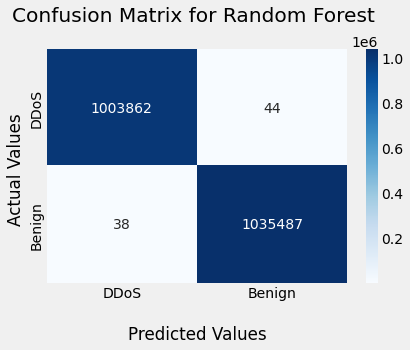

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Confusion matrix for Random Forest

labels = ['DDOS','Benign']
ax = sns.heatmap(RF_cm,annot=True, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for Random Forest \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['DDoS','Benign'])
ax.yaxis.set_ticklabels(['DDoS','Benign'])
plt.show()
plt.savefig('/content/drive/MyDrive/research/RandomForest_cm.png')

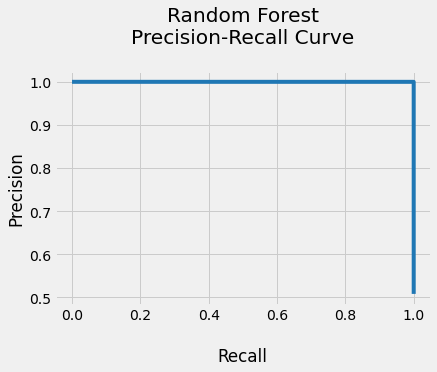

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Precision-Recall Curve for Random Forest

precision, recall, thresholds = precision_recall_curve(y_test, RF_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision,linestyle='-')
ax.set_title('Random Forest\nPrecision-Recall Curve\n')
ax.set_ylabel('Precision')
ax.set_xlabel('\nRecall')

plt.show()
plt.savefig('/content/drive/MyDrive/research/RF_precision-Recall-curve.png')

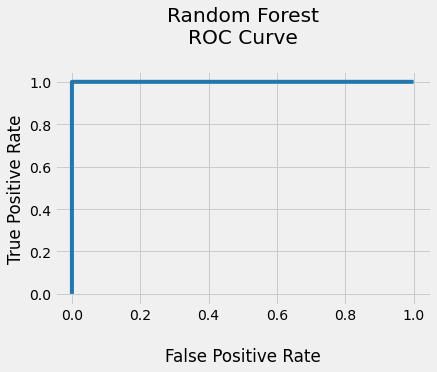

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting ROC curve for Random Forest
RF_roc=roc_auc_score(y_test,RF_pred)
RF_fpr, RF_tpr, _ = roc_curve(y_test,RF_pred)
fig,ax=plt.subplots()
ax.plot(RF_fpr, RF_tpr, linestyle='-', label='Random Forest')
ax.set_title("Random Forest\nROC Curve\n")
ax.set_xlabel('\nFalse Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/research/RF_roc_curve.png')

### Naive bayes


In [ ]:
gnb=GaussianNB()
gnb.fit(X_train,y_train)

GaussianNB()

In [ ]:
#Evaluating Naive Bayes classifier on test set
NB_pred=gnb.predict(X_test)

#Scores
print(accuracy_score(y_test,NB_pred))
print(precision_score(y_test,NB_pred))
print(recall_score(y_test,NB_pred))
print(f1_score(y_test,NB_pred))

0.7986399147605386
0.7286900803186689
0.9613712850969315
0.8290133521643763


In [ ]:
#Classification report
classification_report(y_test,NB_pred)

'              precision    recall  f1-score   support\n\n           0       0.94      0.63      0.76   1003906\n           1       0.73      0.96      0.83   1035525\n\n    accuracy                           0.80   2039431\n   macro avg       0.83      0.80      0.79   2039431\nweighted avg       0.83      0.80      0.79   2039431\n'

In [ ]:
#Confusion matrix
NB_cm=confusion_matrix(y_test,NB_pred)
print(NB_cm)

[[633247 370659]
 [ 40001 995524]]


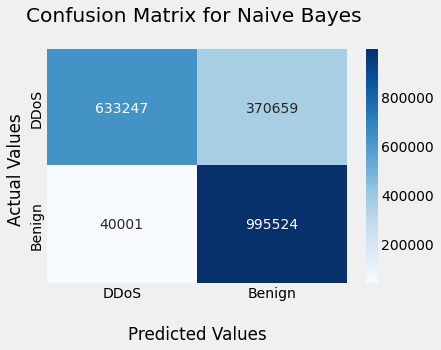

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Confusion matrix for Naive Bayes  Classifier
labels = ['DDOS','Benign']
ax = sns.heatmap(NB_cm,annot=True, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for Naive Bayes \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['DDoS','Benign'])
ax.yaxis.set_ticklabels(['DDoS','Benign'])
plt.show()
plt.savefig('/content/drive/MyDrive/research/NaiveBayes_cm.png')

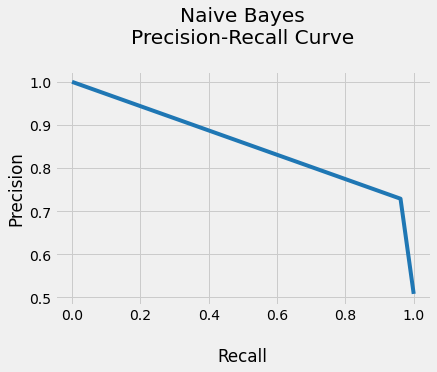

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting precision-recall curve for Naive bayes classifier
precision, recall, thresholds = precision_recall_curve(y_test, NB_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision,linestyle='-')
ax.set_title('Naive Bayes\nPrecision-Recall Curve\n')
ax.set_ylabel('Precision')
ax.set_xlabel('\nRecall')

plt.show()
plt.savefig('/content/drive/MyDrive/research/Naive_bayes-Recall-curve.png')

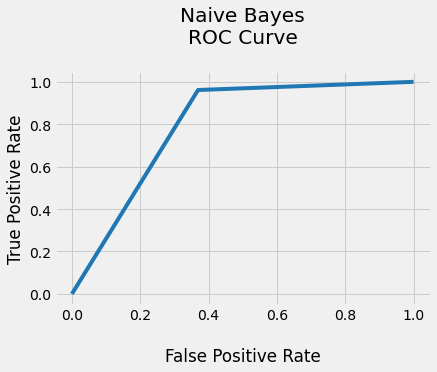

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting ROC curve for Naive Bayes classifier
NB_roc=roc_auc_score(y_test,NB_pred)
NB_fpr, NB_tpr, _ = roc_curve(y_test,NB_pred)
fig,ax=plt.subplots()
ax.plot(NB_fpr, NB_tpr, linestyle='-', label='Naive Bayes')
ax.set_title("Naive Bayes\nROC Curve\n")
ax.set_xlabel('\nFalse Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/research/NB_roc_curve.png')

In [ ]:
gc.collect()

### Logistic regression with sag solver

In [ ]:
logreg=LogisticRegression(solver='sag',random_state=123)
logreg.fit(X_train,y_train)
gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24

In [ ]:
#Evaluating on test set
LR_pred=logreg.predict(X_test)

#Scores
print(accuracy_score(y_test,LR_pred))
print(precision_score(y_test,LR_pred))
print(recall_score(y_test,LR_pred))
print(f1_score(y_test,LR_pred))

0.9776001247406753
0.9763582708995849
0.9796045484174694
0.9779787157633214


In [ ]:
#Classification report
classification_report(y_test,LR_pred)

'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98   1003906\n           1       0.98      0.98      0.98   1035525\n\n    accuracy                           0.98   2039431\n   macro avg       0.98      0.98      0.98   2039431\nweighted avg       0.98      0.98      0.98   2039431\n'

In [ ]:
#Confusion Matrix
LR_cm=confusion_matrix(y_test,LR_pred)
print(LR_cm)

[[ 979343   24563]
 [  21120 1014405]]


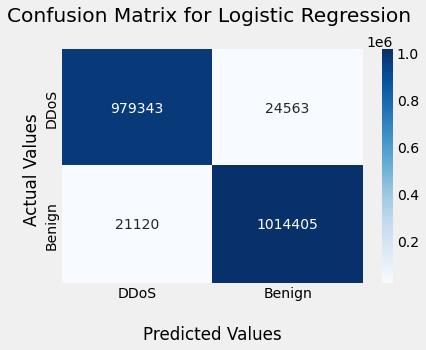

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Confusion matrix for Logistic regressn classifier
labels = ['DDOS','Benign']
ax = sns.heatmap(LR_cm,annot=True, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for Logistic Regression \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['DDoS','Benign'])
ax.yaxis.set_ticklabels(['DDoS','Benign'])
plt.show()
plt.savefig('/content/drive/MyDrive/research/LogisticRegression_cm.png')

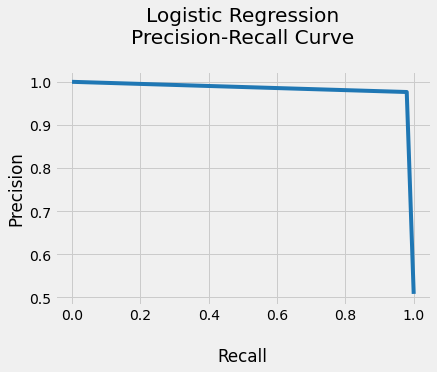

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting precision-recall curve for LR classifier
precision, recall, thresholds = precision_recall_curve(y_test, LR_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision,linestyle='-')
ax.set_title('Logistic Regression\nPrecision-Recall Curve\n')
ax.set_ylabel('Precision')
ax.set_xlabel('\nRecall')

plt.show()
plt.savefig('/content/drive/MyDrive/research/Logistic_Regression-Recall-curve.png')

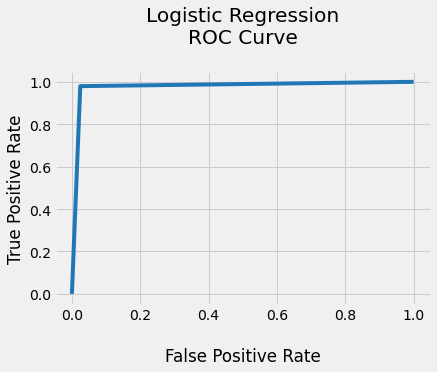

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting ROC curve for LR classifier
LR_roc=roc_auc_score(y_test,LR_pred)
LR_fpr, LR_tpr, _ = roc_curve(y_test,LR_pred)
fig,ax=plt.subplots()
ax.plot(LR_fpr, LR_tpr, linestyle='-', label='Logistic Regression')
ax.set_title("Logistic Regression\nROC Curve\n")
ax.set_xlabel('\nFalse Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/research/Logistic_Regression-roc-curve.png')

In [ ]:
gc.collect()

### LightGBM

In [ ]:
lgb.fit(X_train,y_train)
gc.collect()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


565

In [ ]:
#Evaluating on test set
lgb_pred=lgb.predict(X_test)

#Scores
print(accuracy_score(y_test,lgb_pred))
print(precision_score(y_test,lgb_pred))
print(recall_score(y_test,lgb_pred))
print(f1_score(y_test,lgb_pred))

0.9999293920706315
0.9999092286462804
0.9999517153134884
0.9999304715285738


In [ ]:
#Classification Report
classification_report(y_test,lgb_pred)

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00   1003906\n         1.0       1.00      1.00      1.00   1035525\n\n    accuracy                           1.00   2039431\n   macro avg       1.00      1.00      1.00   2039431\nweighted avg       1.00      1.00      1.00   2039431\n'

In [ ]:
#Confusion matrix
lgb_cm=confusion_matrix(y_test,lgb_pred)
print(lgb_cm)

[[1003812      94]
 [     50 1035475]]


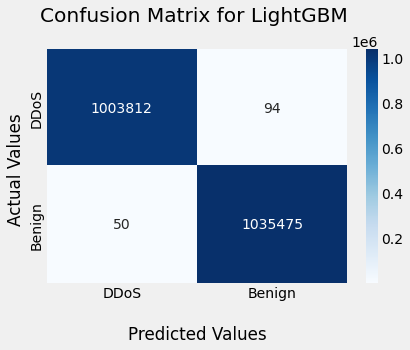

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting confusiin matrix for LightGBM
labels = ['DDOS','Benign']
ax = sns.heatmap(lgb_cm,annot=True, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for LightGBM \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['DDoS','Benign'])
ax.yaxis.set_ticklabels(['DDoS','Benign'])
plt.show()
plt.savefig('/content/drive/MyDrive/research/lgb_cm.png')

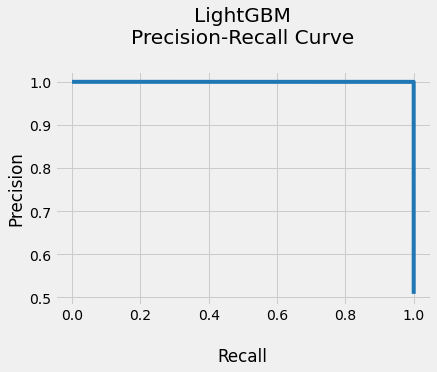

<Figure size 432x288 with 0 Axes>

In [ ]:
#plotting Precision-recall curve for LightGBM 
precision, recall, thresholds = precision_recall_curve(y_test, lgb_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision,linestyle='-')
ax.set_title('LightGBM\nPrecision-Recall Curve\n')
ax.set_ylabel('Precision')
ax.set_xlabel('\nRecall')

plt.show()
plt.savefig('/content/drive/MyDrive/research/LGB-Recall-curve.png')

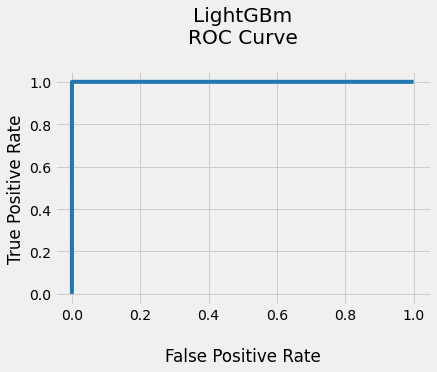

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting ROC curve for LightGBM
lgb_roc=roc_auc_score(y_test,lgb_pred)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test,lgb_pred)
fig,ax=plt.subplots()
ax.plot(lgb_fpr, lgb_tpr, linestyle='-', label='LGB')
ax.set_title("LightGBm\nROC Curve\n")
ax.set_xlabel('\nFalse Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/research/lgb-roc-curve.png')

### CatBoost Classifier


In [ ]:
cbc = CatBoostClassifier(verbose=0, n_estimators=100)
cbc.fit(X_train,y_train)

In [ ]:
cbc_pred=lgb.predict(X_test)
gc.collect()

247

In [ ]:
#Evaluating on test set
cbc_pred=lgb.predict(X_test)

#Scores
print(accuracy_score(y_test,cbc_pred))
print(precision_score(y_test,cbc_pred))
print(recall_score(y_test,cbc_pred))
print(f1_score(y_test,cbc_pred))

0.9999293920706315
0.9999092286462804
0.9999517153134884
0.9999304715285738


In [ ]:
#Classification report
classification_report(y_test,cbc_pred)

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00   1003906\n         1.0       1.00      1.00      1.00   1035525\n\n    accuracy                           1.00   2039431\n   macro avg       1.00      1.00      1.00   2039431\nweighted avg       1.00      1.00      1.00   2039431\n'

In [ ]:
#Confusion matrix
cbc_cm=confusion_matrix(y_test,cbc_pred)
print(cbc_cm)

[[1003812      94]
 [     50 1035475]]


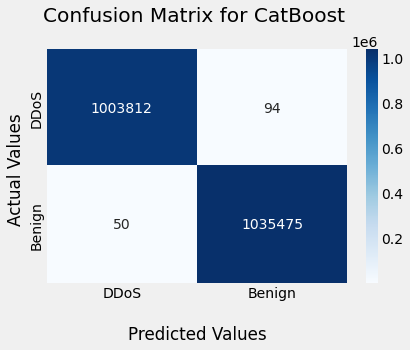

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Confusion matrix for CatBoost
labels = ['DDOS','Benign']
ax = sns.heatmap(lgb_cm,annot=True, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix for CatBoost \n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['DDoS','Benign'])
ax.yaxis.set_ticklabels(['DDoS','Benign'])
plt.show()
plt.savefig('/content/drive/MyDrive/research/cbc_cm.png')

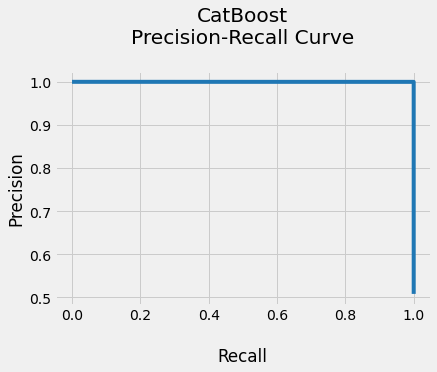

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting precision-recall curve for CatBoost
precision, recall, thresholds = precision_recall_curve(y_test, cbc_pred)
fig, ax = plt.subplots()
ax.plot(recall, precision,linestyle='-')
ax.set_title('CatBoost\nPrecision-Recall Curve\n')
ax.set_ylabel('Precision')
ax.set_xlabel('\nRecall')

plt.show()
plt.savefig('/content/drive/MyDrive/research/cbc-Recall-curve.png')

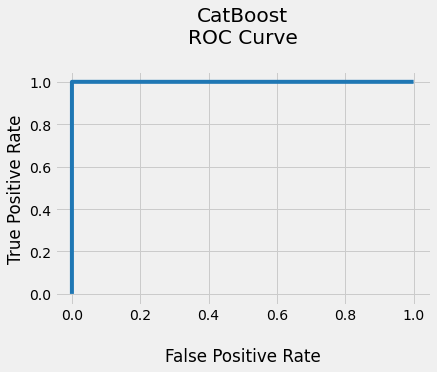

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting  ROC cruve for CatBoost
cbc_roc=roc_auc_score(y_test,cbc_pred)
cbc_fpr, cbc_tpr, _ = roc_curve(y_test,cbc_pred)
fig,ax=plt.subplots()
ax.plot(lgb_fpr, lgb_tpr, linestyle='-', label='CBC')
ax.set_title("CatBoost\nROC Curve\n")
ax.set_xlabel('\nFalse Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.show()
plt.savefig('/content/drive/MyDrive/research/cbc-roc-curve.png')

In [ ]:
gc.collect()

8748